In [1]:
print('These are Vance Nygard\'s solutions for hw04.')

These are Vance Nygard's solutions for hw04.


In [3]:
#Import Zone (Duty Free)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates
import calendar
import glob
import scipy.stats
import time
import matplotlib.cm as cm

In [26]:
#Problem 1

class Merrimack(object):
    def __init__(self,file_name,target_year):
        file = open(file_name)
        self.discharge = []
        self.date = []
        self.date_plot = []
        for line in file.readlines():
            if line.split()[0] == 'USGS':
                year = int(line.split('\t')[2][0:4])
                if year == target_year:
                    month = int(line.split('\t')[2][5:7])
                    day = int(line.split('\t')[2][8:10])
                    self.date.append(datetime.datetime(year,month,day))
                    self.date_plot.append(datetime.datetime(2000,month,day))
                    self.discharge.append(int(line.split('\t')[3])/35.315)
        
        self.discharge = np.asarray(self.discharge)
        self.date = np.asarray(self.date)

    def generate_366(self):
            head = self.date[0]
            tail = self.date[-1]
            self.dis_366 = np.zeros(366)
            if len(self.date)==365 or len(self.date)==366:
                self.dis_366 = self.leap_year(head.year)
            elif head.month != 1 or head.day != 1:
                day_num = (head - datetime.datetime(head.year,1,1)).days
                nan_array = np.zeros(day_num)
                nan_array[:] = np.nan
                self.discharge = np.hstack((nan_array,self.discharge))
                self.dis_366 = self.leap_year(head.year)
            elif tail.month != 12 or tail.day != 31:
                day_num = (datetime.datetime(tail.year,12,31) - tail).days
                nan_array = np.zeros(day_num)
                nan_array[:] = np.nan
                self.discharge = np.hstack((self.discharge, nan_array))
                self.dis_366 = self.leap_year(tail.year)
            return self.dis_366

    def leap_year(self, year):
        dis_gen = np.zeros(366)
        dis_gen[:] = np.nan
        if not calendar.isleap(year):
            dis_gen[0:31+28] = self.discharge[0:31+28]
            dis_gen[31+29:]  = self.discharge[31+28:]
        else:
            dis_gen = self.discharge
        return dis_gen        

In [30]:
#Problem 1, continued: Gathering Data for Four Target_Years; Calculated Average and Std. Dev.
file_name = '../python4geosciences/data/merrimack_discharge.dat'
data_1936 = Merrimack(file_name, 1936)
data_1938 = Merrimack(file_name, 1938)
data_1960 = Merrimack(file_name, 1960)
data_1987 = Merrimack(file_name, 1987)

mask_dis = np.zeros(366)
for i in range(1923,2005):
    data = Merrimack(file_name,i)
    mask_dis = np.vstack((mask_dis, data.generate_366()))
    
mean = np.nanmean(mask_dis,axis=0)
std  = np.nanstd(mask_dis,axis=0)

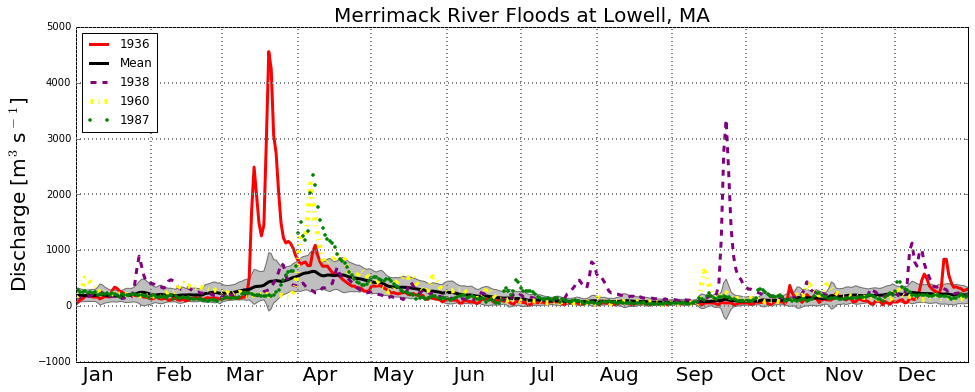

In [31]:
#Problem 1, continued: Graphing Data
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(111)  
ax.set_title('Merrimack River Floods at Lowell, MA', size = 20)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('       %b'))
ax.grid(True, color='gray', linewidth=2)
plt.xticks(size = 20)
ax.set_ylabel('Discharge [m$^3$ s$^-$$^1$]', size = 20)
plt.plot(data_1936.date_plot, data_1936.discharge, linewidth = 3, color = 'red', label = '1936')
ax.xaxis.set_ticks_position('none')

plt.fill_between(data_1936.date_plot, mean+std, mean-std, facecolor='grey',alpha =0.5)
plt.plot(data_1936.date_plot, mean, linewidth = 3, color = 'k', label = 'Mean')

ax2 = fig.add_subplot(111)  
plt.plot(data_1938.date_plot, data_1938.discharge, linestyle = 'dashed',linewidth = 3, color = 'purple', label = '1938')

ax3 = fig.add_subplot(111)  
plt.plot(data_1960.date_plot, data_1960.discharge, linestyle = 'dashdot',linewidth = 5, color = 'yellow', label = '1960')

ax4 = fig.add_subplot(111)  
plt.plot(data_1987.date_plot, data_1987.discharge, '.',linewidth = 4, color = 'green', label = '1987')
# ax4.legend(numpoints = 4)

plt.legend(fontsize = 'large', loc = 'upper left')

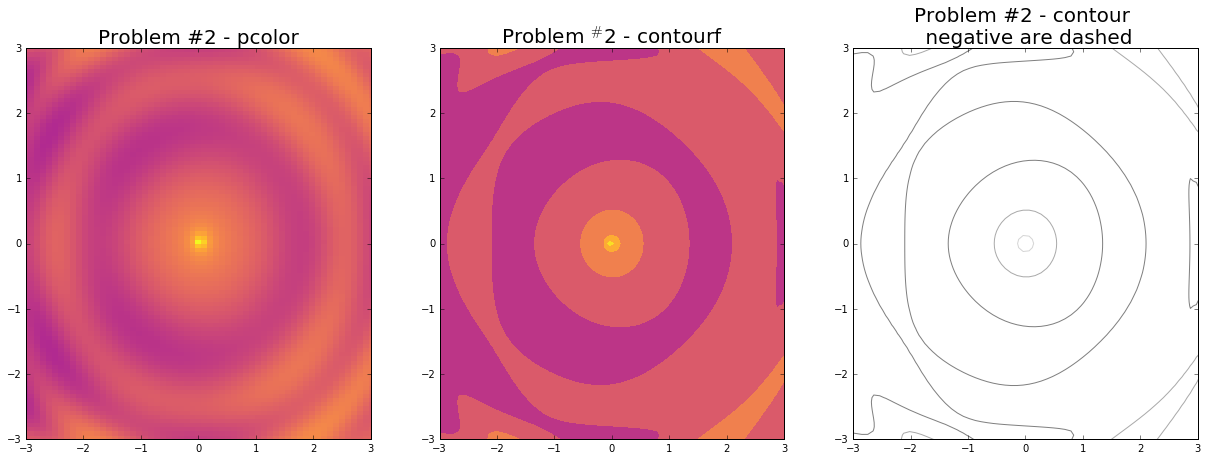

In [26]:
# Problem 2

X, Y = np.meshgrid(np.linspace(-4.2, 6.2, 101), np.linspace(-3.2, 3.2, 101))
Z = np.cos(X**2+Y**2)*(X**2+Y**2)**-0.25 + 0.2*X*Y*np.sin(Y) + 0.01*X*Y**4*np.sin(X) + 0.2*np.exp(-Y**2)

fig = plt.figure(figsize=(21,7))
ax = fig.add_subplot(1, 3, 1)
ax.pcolor(X, Y, Z, cmap = 'plasma')
ax.axis([-3, 3, -3, 3])
ax.set_title('Problem #2 - pcolor', fontsize=20)
# mappable = ax.pcolor(Z, cmap='plasma', vmin=Z.min(), vmax= Z.max())

ax2 = fig.add_subplot(1, 3, 2)
ax2.contourf(X, Y, Z, cmap = 'plasma')
ax2.axis([-3, 3, -3, 3])
ax2.set_title('Problem $^\#$2 - contourf', fontsize=20)

ax3 = fig.add_subplot(1, 3, 3)
ax3.contour(X, Y, Z, cmap = 'gray', linewidth = 5, negative_linestyle = 'dashed', negative_linewidth = 5)
ax3.axis([-3, 3, -3, 3])
ax3.set_title('Problem #2 - contour \n negative are dashed', fontsize=20)

# fig.colorbar(mappable)

In [8]:
#Problem 3: Largely copied from my hw03

class dataclass(object):
    def __init__(self,filename):
        f = open(filename)
        switch = 0
        self.temp = []
        self.salt = []
        self.depth = []
        self.tran = []
        
        
        for line in f.readlines():
            if switch == 1: 
                self.temp.append(line.split()[2])
                self.salt.append(line.split()[5])
                self.depth.append(line.split()[1])
                self.tran.append(line.split()[9])
            if line.split()[0] == '*END*': switch = 1
        
        self.temp = np.asarray(self.temp, dtype = 'float64')
        self.salt = np.asarray(self.salt, dtype = 'float64')
        self.depth = np.asarray(self.depth, dtype = 'float64')
        self.tran = np.asarray(self.tran, dtype = 'float64')
    

file_group = glob.glob('../python4geosciences/data/MCH/*.cnv2')
wave = []
for filename in file_group:
    wave.append(dataclass(filename))

salt_data = wave[0].salt
for i in range(1,len(wave)):
    salt_data = np.hstack((salt_data, wave[i].salt))
    
temp_data = wave[0].temp
for i in range(1,len(wave)):
    temp_data = np.hstack((temp_data, wave[i].temp))

depth_data = wave[0].depth
for i in range(1,len(wave)):
    depth_data = np.hstack((depth_data, wave[i].depth))
    
tran_data = wave[0].tran
for i in range(1,len(wave)):
    tran_data = np.hstack((tran_data, wave[i].tran))

In [9]:
# Problem 3; Directions: Read 2D data and make scatter plot

# Temperature and salinity are known to have an important relationship in oceanography. 
# Investigate that relationship in the CTD data from one of the files stored in data/MCH. 
# Read in the data and make the following plots as subplots in one figure:

#     plot temperature vs. salinity, using black dots to mark the data points.
#     plot temperature vs. salinity, and color the markers with the depth;
#     plot temperature vs. salinity, color the markers with the depth,
#            and then size the markers with another property of your choice from the file.

# Choose a colormap that is different from the default to use for the colors of your markers for the 2nd and 3rd plots.


D:\Program Files\Anaconda\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: Tried to set a label via parameter 'y' in func 'scatter' but couldn't find such an argument. 
(This is a programming error, please report to the matplotlib list!)


TypeError: scatter() missing 1 required positional argument: 'y'

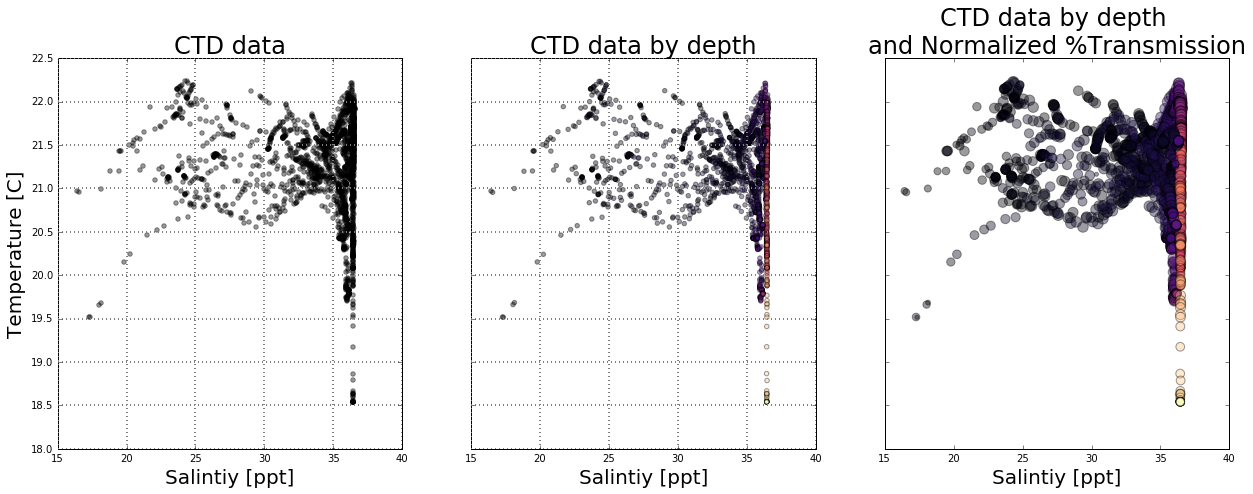

In [68]:
#Problem 3, continued
X = salt_data
Y = temp_data
Z = depth_data
A = tran_data
A_avg = np.average(tran_data)
A_normal = A / A_avg * 100

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(21,7))
axes[0].scatter(X, Y, c='k', alpha=0.4)
axes[0].set_title('CTD data',size = 24)
axes[0].set_xlabel('Salintiy [ppt]', size = 20)
axes[0].set_xlim([15,40])
axes[0].set_ylabel('Temperature [C]', size = 20)
axes[0].grid(True, color='gray', linewidth=2)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)

s_map = axes[1].scatter(X, Y, cmap = cm.magma, c=Z, alpha=0.4)
axes[1].set_title('CTD data by depth',size = 24)
axes[1].set_xlabel('Salintiy [ppt]', size = 20)
axes[1].grid(True, color='gray', linewidth=2)

axes[2].scatter(X, Y, cmap = cm.magma, c=Z, s=A_normal, alpha=0.4)
axes[2].set_title('CTD data by depth \nand Normalized %Transmission',size = 24)
axes[2].set_xlabel('Salintiy [ppt]', size = 20)
# mappable = ax5.pcolormesh(Z*2, cmap='viridis', vmin=dmin, vmax=dmax)
mappable = axes[2].scatter(Z, cmap='magma', vmin=0, vmax=100)
axes[2].grid(True, color='gray', linewidth=2)

fig.colorbar(mappable)

In [66]:
axes[2].scatter?

SyntaxError: invalid syntax (<ipython-input-66-78d64a2c7c69>, line 1)

In [ ]:
axes[2].scatter

In [79]:
#Problem 4. Histogram

# Make a 1D histogram of wind speed from the BURL1 NOAA weather station.

# Bonus: What kind of probability distribution does this look like?
# Plot your best guess on top of the histogram using a line.

burl = np.genfromtxt('http://www.ndbc.noaa.gov/view_text_file.php?filename=burl1h2010.txt.gz&dir=data/historical/stdmet/')
wind_speed = burl[:, 6]

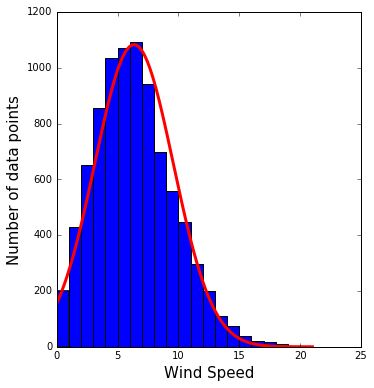

In [89]:
x_coord = np.linspace(0,21, len(wind_speed)) #These are the x-axis values.
m, s = scipy.stats.norm.fit(wind_speed)  #These are the y-axis values.
regress = scipy.stats.norm.pdf(x_coord, m, s)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(wind_speed, bins=21)
ax1.set_xlabel('Wind Speed', fontsize = 15)
ax1.set_ylabel('Number of data points', fontsize = 15)
plt.plot(x_coord, regress*len(wind_speed), '-',color = 'r', linewidth = 3)

#This looks like a log-normal probability distribution.

In [29]:
#Problem 5
mauna_loa_co2 = np.genfromtxt('ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt')
timestamp = []
co2_total = []
plot_x = []

for i, line in enumerate(mauna_loa_co2):
    goodtime = mauna_loa_co2[i, 2]
    years = int(mauna_loa_co2[i, 0])
    months = int(mauna_loa_co2[i, 1])
    days = 1
    co2 = mauna_loa_co2[i, 4]

    timestamp.append(goodtime)
#     timestamp.append((datetime.datetime(years, months, days)))
    co2_total.append(co2)
#     print(datetime.datetime(years, months, days).timetuple())
    plot_x.append(goodtime)

a = np.polyfit(plot_x, co2_total, 1)
b = np.polyfit(plot_x, co2_total, 2)
c = np.polyfit(plot_x, co2_total, 5)
print(a)
print()
print(b)
print()
print(c)

[  1.51022538e+00  -2.64982010e+03]

[  1.21983758e-02  -4.69691698e+01   4.55140792e+04]

[ -1.35973203e-07   1.35815240e-03  -5.42605209e+00   1.08385261e+04
  -1.08244981e+07   4.32401303e+09]


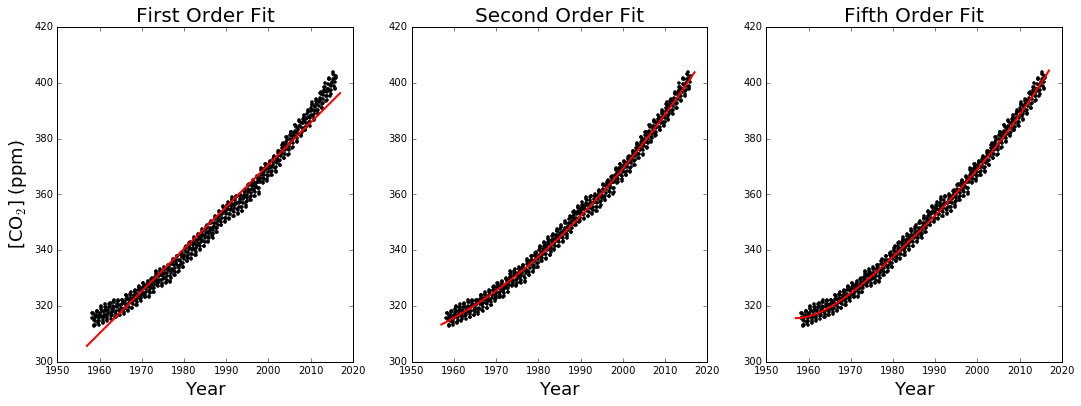

In [38]:
#Problem 5, continued
x1 = np.linspace(1957,2017, 2)
y1 = 1.5102254*x1 - 2649.82
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 3, 1)
plt.plot(timestamp, co2_total, '.', color = 'k')
ax.set_title('First Order Fit', size=20)
ax.set_ylabel('[CO$_2$] (ppm)', fontsize = 18)
ax.set_xlabel('Year', fontsize = 18)
plt.plot(x1,y1,'-', color = 'r', linewidth = 2)

x2 = np.linspace(1957,2017, 60)
y2 = 1.21983758e-02 * x2**2 - 46.9691698 * x2 + 4.55140792e+04
ax2 = fig.add_subplot(1, 3, 2)
plt.plot(timestamp, co2_total, '.', color = 'k')
ax2.set_title('Second Order Fit', size=20)
ax2.set_xlabel('Year', fontsize = 18)
plt.plot(x2,y2,'-', color = 'r', linewidth = 2)

x3 = np.linspace(1957,2017, 60)
y3 = -1.35973203e-07 * x3**5 + 1.35815240e-03 *x3**4 - 5.42605209e+00 *x3**3 + 1.08385261e+04*x3**2 - 1.08244981e+07*x3 + 4.32401303e+09 - 45
ax3 = fig.add_subplot(1, 3, 3)
plt.plot(timestamp, co2_total, '.', color = 'k')
ax3.set_title('Fifth Order Fit', size=20)
ax3.set_xlabel('Year', fontsize = 18)
plt.plot(x3,y3,'-', color = 'r', linewidth = 2)

#This is most likely a third order fit. The X^5 and X^4 terms are very small, so they don't add much to the equation.
#The y-intercept of the 5th order equation is so big (~4,000,000,000) that an additional term of -45 had to be appended, as significant figures limited the y-intercept from getting close enough.  

In [73]:
#Problem 6 in separate file:
# hw04-problem6-solution-nygard.ipynb